In [11]:
import torch
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

class BoltzmannMachine:
    def __init__(self, nv, nh):
        self.nv = nv
        self.nh = nh
        
        # Initialize weight matrix with random values
        self.W = np.random.randn(nv, nh)
        
        # Initialize visible and hidden biases
        self.a = np.random.randn(nv)
        self.b = np.random.zeros(nh)

    def partition_function(self):
        z = 0
        possible_h = []
        possible_v = []
        return z
    def sample_hidden_units(self, visible_units):
        activation = np.dot(visible_units, self.W) + self.b
        prob_hidden_units = self.sigmoid(activation)
        hidden_units = np.random.binomial(1, prob_hidden_units)
        return hidden_units

    def sample_visible_units(self, hidden_units):
        activation = np.dot(hidden_units, self.W.T) + self.a
        prob_visible_units = self.sigmoid(activation)
        visible_units = np.random.binomial(1, prob_visible_units)
        return visible_units

    def prob_hidden_units(self, visible_units):
        activation = np.dot(visible_units, self.W) + self.b
        prob_hidden_units = self.sigmoid(activation)
        return prob_hidden_units

    def prob_visible_units(self, hidden_units):
        activation = np.dot(hidden_units, self.W.T) + self.a
        prob_visible_units = self.sigmoid(activation)
        return prob_visible_units

    def gibbs_sampling(self, visible_units_k):
        hidden_units_k = self.sample_hidden_units(visible_units_k)
        visible_units_k = self.sample_visible_units(hidden_units_k)
        return visible_units_k, hidden_units_k

    def update_weights(self, visible_units_0, hidden_units_0, visible_units_k, hidden_units_k, learning_rate):
        positive_grad = np.outer(visible_units_0, hidden_units_0)
        negative_grad = np.outer(visible_units_k, hidden_units_k)
        self.W += learning_rate * (positive_grad - negative_grad)
        self.a += learning_rate * (visible_units_0 - visible_units_k)
        self.b += learning_rate * (hidden_units_0 - hidden_units_k)

    def train(self, train_data, epochs, learning_rate, k_iterations):
        for epoch in range(epochs):
            for data in train_data:
                # Gibbs Sampling
                visible_units_0 = data
                hidden_units_0 = self.sample_hidden_units(visible_units_0)
                
                visible_units_k, hidden_units_k = self.gibbs_sampling(visible_units_0)
                
                # Update weights and biases
                self.update_weights(visible_units_0, hidden_units_0, visible_units_k, hidden_units_k, learning_rate)
        
    def recognize(self, test_data, k_iterations):
        recognized_chars = []
        for data in test_data:
            visible_units_0 = data
            hidden_units_0 = self.sample_hidden_units(visible_units_0)
            
            # Perform Gibbs Sampling to get visible units after k iterations
            for _ in range(k_iterations):
                visible_units_k, hidden_units_k = self.gibbs_sampling(visible_units_0)

            # Choose the most probable visible unit
            recognized_char = np.argmax(visible_units_k)
            recognized_chars.append(recognized_char)
        
        return recognized_chars

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))


ValueError: cannot reshape array of size 100 into shape (28,28)

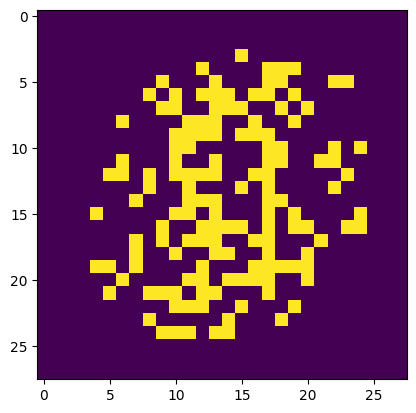

In [30]:
# Load MNIST training dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create a list to store the training data
train_data = []
for data, _ in train_loader:
    train_data.append(torch.flatten(data).numpy())
train_data = np.array(train_data)

visible_units = train_data.shape[1]
hidden_units = 20
epochs = 5
learning_rate = 0.1
k_iterations = 64

# Create a Boltzmann Machine object
boltzmann_machine = BoltzmannMachine(visible_units, hidden_units)

# Run the training process
boltzmann_machine.train(train_data, epochs, learning_rate, k_iterations)

# Generate a random visible unit as input for testing
test_input = np.random.binomial(1, 0.5, visible_units)

# Perform Gibbs Sampling with k iterations on the test input
test_output,_ = boltzmann_machine.gibbs_sampling(test_input)

# Reshape the test output into a 28x28 image
test_output_image = test_output.reshape((28, 28))

# Display the test output image
import matplotlib.pyplot as plt
plt.imshow(test_output_image)

784


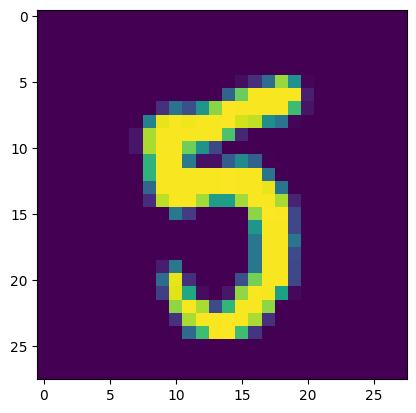

In [19]:
# Reshape the test output into a 28x28 image
test_output_image = train_data[3].reshape((28,28))

# Display the test output image
import matplotlib.pyplot as plt
plt.imshow(test_output_image)


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np

# 1. Problem Statement and Context:
#   We want to train a Restricted Boltzmann Machine (RBM) on the MNIST dataset and then use the trained model to identify handwritten digits.

# 2. Algorithm and Approach:
#   - Load the MNIST training dataset.
#   - Preprocess the data and train an RBM.
#   - Use the trained RBM to identify digits from new images.

# 3. Pseudocode or High-Level Logic:
#   - Load and preprocess MNIST dataset.
#   - Train an RBM on the dataset.
#   - Given a new image, flatten it and pass it through the RBM.
#   - The RBM output can be used for digit identification.

# Load MNIST training dataset
train_dataset = datasets.MNIST('./data', train=True, download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

# Create a list to store the training data
train_data = []
for data, _ in train_loader:
    train_data.append(torch.flatten(data).numpy())
train_data = np.array(train_data)

# 4. Code Implementation:

# Define the RBM model
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(visible_units, hidden_units))
        self.bv = nn.Parameter(torch.randn(visible_units))
        self.bh = nn.Parameter(torch.randn(hidden_units))

    def forward(self, v):
        ph_given_v = torch.sigmoid(torch.matmul(v, self.W) + self.bh)
        h_sample = torch.bernoulli(ph_given_v)
        pv_given_h = torch.sigmoid(torch.matmul(h_sample, self.W.t()) + self.bv)
        return pv_given_h, h_sample

# Training parameters
visible_units = 784  # MNIST images are 28x28 pixels
hidden_units = 256
learning_rate = 0.1
batch_size = 64
num_epochs = 10

# Initialize RBM
rbm = RBM(visible_units, hidden_units)

# Training loop
for epoch in range(num_epochs):
    total_loss = 0.0
    for i in range(0, train_data.shape[0], batch_size):
        batch = train_data[i:i + batch_size]
        v = torch.tensor(batch, dtype=torch.float32)
        pv_given_h, h_sample = rbm(v)

        loss = torch.mean((v - pv_given_h) ** 2)
        total_loss += loss.item()

        rbm.zero_grad()
        loss.backward()
        rbm.W.grad /= len(batch)
        rbm.bv.grad /= len(batch)
        rbm.bh.grad /= len(batch)

        rbm.W.data += learning_rate * rbm.W.grad.data
        rbm.bv.data += learning_rate * rbm.bv.grad.data
        rbm.bh.data += learning_rate * rbm.bh.grad.data

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_data)}")

# 5. Input and Output Handling:
#   - To identify a digit from a new image, you can flatten the image and pass it through the trained RBM.
#   - The RBM output can be analyzed to determine the identified digit.

# 6. Error Handling and Exception Cases:
#   - Ensure that the input image to the RBM matches the size (784 dimensions) and preprocessing of MNIST training data.

# 7. Testing and Validation:
#   - To validate the code, you can test it by providing a new image and checking the RBM's output for digit identification.

# 8. Efficiency and Optimization:
#   - This code provides a basic RBM implementation. Further optimization and fine-tuning are possible.

# 9. Modularity and Comments:
#   - The code is written in a modular fashion. Comments are provided to explain key steps.

# 10. Documentation and Usage Instructions:
#   - This code is a snippet for training an RBM on MNIST. You can use it as part of a larger project for digit identification.

# 11. Dependencies and Libraries:
#   - PyTorch for deep learning operations.
#   - torchvision for dataset loading and preprocessing.

# 15. Summary and Conclusion:
#   - This code demonstrates how to train a Restricted Boltzmann Machine (RBM) on the MNIST dataset and use it for digit identification. Further integration with a digit identification system is needed for a complete application.

# 16. Acknowledgments:
#   - MNIST dataset: http://yann.lecun.com/exdb/mnist/


In [ ]:
import matplotlib.pyplot as plt
import random

# Function to display an image
def show_image(image, title):
    plt.figure()
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Randomly select an image from the MNIST dataset
index = random.randint(0, len(train_data))
sample_image = train_data[index]

# Display the original image
show_image(sample_image, "Original Image")

# Pass the image through the trained RBM to generate a reconstructed image
v = torch.tensor(sample_image, dtype=torch.float32)
pv_given_h, _ = rbm(v)

# Display the reconstructed image
show_image(pv_given_h.detach().numpy(), "Reconstructed Image")
